# 모델러닝 중 전처리 작업을 위해 만든 파일

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pyarrow.parquet as pq
import tqdm
import optuna
import matplotlib.font_manager as fm


# test 데이터 준비 (샘플로 train에서 분리)
from sklearn.model_selection import train_test_split

# 모델 학습 및 평가
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score


# notebook이 있는 디렉토리를 절대경로로 설정
notebook_dir = r'c:\Users\Administrator\github\Credit-Card-Segment\LGW'

# sys.path에 추가 (중복 확인)
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

# 작업 디렉토리 변경
os.chdir(notebook_dir)
from corr_dict import corr_dict

c:\Users\Administrator\miniconda3\envs\Sub\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
HOME = os.getcwd()
list_dir = os.listdir(HOME)

In [3]:
list_dir

['1.corr.common.txt',
 '1.corr.txt',
 '2.corr.txt',
 '240_Segment.parquet',
 '3.corr.txt',
 '4.corr.txt',
 '5.corr.txt',
 '6.corr.txt',
 '7.corr.txt',
 '8.corr.txt',
 'backup',
 'catboost_info',
 'corr_dict.py',
 'corr_Name_backup.txt',
 'credit_preprocessing_month_10.parquet',
 'credit_preprocessing_month_11.parquet',
 'credit_preprocessing_month_12.parquet',
 'credit_preprocessing_month_7.parquet',
 'credit_preprocessing_month_8.parquet',
 'credit_preprocessing_month_9.parquet',
 'data',
 'Data_Analysis.ipynb',
 'Data_Analysis_Lite.ipynb',
 'Data_Analysis_Main.ipynb',
 'Data_Analysis_Sub.ipynb',
 'Data_Analysis_Sub_2.ipynb',
 'Data_Analysis_Sub_3.ipynb',
 'LGW Read me',
 'merge_data.ipynb',
 'merge_data_feedback.ipynb',
 'Segment_Correlation_Pearson',
 'Segment_Correlation_Spearman.txt',
 'test',
 '_1st_corr.txt',
 '__pycache__']

### 시작 전 준비
 - 858개라는 방대한 데이터를 가지게 됬지만, 이는 세부적인 사항을 고려하지 못할수도 있다. 따라서, 나중에 세부사항을 파악하기 위해서 따로 사용할 코드를 하나 더 만들어 놓는다.

In [4]:
# 함수로 만들어서 넣어버리자 그냥
# 각 폴더명 딕셔너리
HOME = os.getcwd()
def makeFileList(option = "train"):
    folder_name = {1:"1.회원정보", 2:"2.신용정보", 3:"3.승인매출정보", 4:"4.청구입금정보", 5:"5.잔액정보", 6:"6.채널정보", 7:"7.마케팅정보", 8:"8.성과정보"}

    # 현재 디렉터리
    HOME = os.getcwd()

    # 폴더 리스트를 생성하고 폴더 경로들을 리스트로 저장하기
    folder_list = []
    for value in folder_name.values():
        folder_list.append(os.path.join(HOME, "data", option, value))
    print(len(folder_list))

    # 폴더 내 파일 리스트 읽어오기
    fileNameList = {}
    for i in range(len(folder_list)):
        fileNameList[i+1] = os.listdir(folder_list[i])
    print(fileNameList)

    # 파일 경로 리스트 생성
    filePathList = {}
    temp = []
    for i in range(len(folder_list)):
        for j in range(len(fileNameList[i+1])):
            temp.append(os.path.join(folder_list[i], fileNameList[i+1][j]))
        filePathList[i+1] = temp
        temp = []

    return filePathList

In [5]:
# 메모리를 32비트로 변환
def optimize_memory(df):
    for col in df.select_dtypes(include=['number']).columns:
        # 정수형은 가능한 가장 작은 타입으로 (int8, int16 등)
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        # 실수형은 float32로
        elif df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

In [6]:
# 240만개의 파일을 이어 붙이기
# 각 폴더에 들어있는 파일들 중 같은 달의 열을 모두 합침
def load_cat(i, filePathList):
    print("현재 진행 상황 : {}".format(i))
    df = optimize_memory(pd.read_parquet(filePathList[i][0]))
    for j in range(1,6):
        print("Debugging1")
        df = pd.concat([df, optimize_memory(pd.read_parquet(filePathList[i][j]))])
    return df

# 공통된 쓸모없는 column 제거 함수=
def drop_useless(df):
    df = df.drop(columns = ["기준년월", "ID"])
    return df
# target인 Segment가 없을시 Segment 추가
def add_target(df, filePathList):# target이 존재하지 않는 df, target명(문자열)
    temp_df = pd.read_parquet(filePathList[1][0])
    for i in range(1, 6):
        temp_df = pd.concat([temp_df, pd.read_parquet(filePathList[1][i])])
    df = pd.merge(temp_df[["기준년월", "ID", "Segment"]], df, on = ["기준년월","ID"],how = "left")
    return df

# 파일을 불러오는 함수
def make_df(i, option = False):# option이 True면 Test데이터도 불러오게 하자.

    # train 데이터 불러오기
    train = makeFileList()
    test = makeFileList(option = "test")
    train = load_cat(i, train)

    # test 데이터 불러오기
    if option == "all":
        train = pd.DataFrame()
        for i in range(1, 9):
            train = pd.concat([train, drop_useless(load_cat(i, makeFileList()))], axis = 1)    
        test = pd.DataFrame()
        for i in range(1, 9):
            test = pd.concat([test, drop_useless(load_cat(i, makeFileList(option = "test")))], axis = 1)
    elif option:
        train = drop_useless(add_target(train, makeFileList()))
        test = drop_useless(load_cat(i, test))

    
    # option 이 True 라면 concat해서 붙여넣기 : if로 하지 않으면 앞에 test를 선언했기 때문에 오류 날 것
    if option:
        print(train.shape)
        print(test.shape)

        result = pd.concat([train, test], ignore_index=True)
        print(result.shape)
        return result
    else :
        print(train.shape)
        if (i > 1) & (i <= 6): train = add_target(train, makeFileList())
        elif i == 1: return drop_useless(train)
        else: print("숫자가 아니거나 할당 없는 카테고리입니다.")
        return drop_useless(train)
    # i 가 1보다 크고 1보다 작을때 사용



# 데이터프레임에서 파라미터를 입력하면 그 파라미터가 포함된 column들을 가져와 새로운 데이터프레임을 반환함
# 연관성 있는 column들을 얻어오기 위해서 사용한다.
def find_R(df, param1):
    columns = list(df.columns)
    new_columns = []
    for column in columns:
        if param1 in column:
            new_columns.append(column)
    return pd.DataFrame(df[new_columns])

In [7]:
def corr_maker(df, filename= False, method = "pearson",target = False, map = False):

    # 1. 데이터 복사 (원본 데이터프레임 보호)    
    temp_df = df.copy()
    if map:
        mapping = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'E': 0}
        temp_df["Segment"] = temp_df["Segment"].map(mapping)

    # 2. 문자열 컬럼만 골라내기
    obj_cols = temp_df.select_dtypes(include=['object']).columns

    # 3. 문자열 컬럼만 factorize 적용
    for col in obj_cols:
        temp_df[col] = pd.factorize(temp_df[col])[0]

    # 4. 전체 상관관계 계산 (스피어먼 방식)
    corr_matrix = temp_df.corr(method = method)# method = spearman

    # 5. 특정 컬럼('Segment') 기준 추출
    target_col = "Segment"
    if target_col in corr_matrix.columns:
        target_corr = corr_matrix[target_col].sort_values(ascending=False)
        result_series = target_corr.drop(target_col)
        
        # --- [추가된 부분: 파일 저장] ---
        if filename:
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(f"[{target_col}] 기준 상관관계 순위 (Spearman):\n")
                f.write("-" * 50 + "\n")
                f.write(result_series.to_string())
                f.write("\n" + "-" * 50)
                print(f"결과가 {filename}에 저장되었습니다.")
        print(result_series)
        # -------------------------------
    else:
        print(f"'{target_col}' 컬럼이 데이터에 없습니다.")
# 만들어 놓은 corr파일을 읽어오는 함수
def read_corr(filename = False):
    if filename:
        f = open(filename, "r")
        Segment_corr = []
        temp = f.readline()
        temp = f.readline()

        while True:
            temp = f.readline()
            temp = [temp.split()[0], float(temp.split()[-1])]
            if str(temp[1]) == "nan":
                break
            else:
                Segment_corr.append(temp)
        f.close()
        return Segment_corr
    else:
        print("Please Enter filename")
# 주의 : 상관관계들이 모두 절대값이 된다.
# 상관관계를 정렬하는 함수
def sort_corr(corrs):
    new_corr = []
    for corr in corrs:
        new_corr.append([corr[0], abs(corr[1])])   
    new_corr = sorted(new_corr, key = lambda x:x[1], reverse = True)
    return new_corr

# 일정치 이상의 corr만 남기는 함수
def filter_high_corr(corrs, filter = 0.2):
    new_corr = []
    for corr in corrs:
        if (corr[1] >= filter) | (corr[1]<= -filter):
            new_corr.append(corr)
    return new_corr

In [8]:
def read_corr(filename=False):
    if filename:
        f = open(filename, "r", encoding='utf-8')
        Segment_corr = []
        temp = f.readline()
        temp = f.readline()

        while True:
            temp = f.readline()
            # 빈 줄이거나 줄 끝에 도달한 경우 루프 탈출
            if not temp or not temp.strip():
                break
            
            split_temp = temp.split()
            # split 결과가 충분한 요소를 가지고 있는지 확인
            if len(split_temp) < 2:
                break
            
            try:
                temp = [split_temp[0], float(split_temp[-1])]
                if str(temp[1]) == "nan":
                    break
                else:
                    Segment_corr.append(temp)
            except ValueError:
                # float 변환 실패 시 루프 탈출
                break
        
        f.close()
        return Segment_corr
    else:
        print("Please Enter filename")

In [9]:
# 리스트에 추가하는 함수
def add_list(origin , columns):
    if(type(columns) == list):
        for column in columns:
            origin.append(column)
    elif type(columns) == str:
        origin.append(columns)

In [10]:
# 0과 1로 이루어진 데이터들 중, 상대적으로 부족한 A, B에 대해서 확실히 평가를 끌어내 줄 수 있지 않을까 싶어서 가져온 자료
def plot_segment_comparison(df, column):
    """
    Segment와 지정된 column의 관계를 stacked bar chart와 heatmap으로 시각화
    1행 2열 subplot
    
    Parameters:
    -----------
    df : DataFrame
        데이터프레임
    column : str
        비교할 column 이름 (예: "회원여부_연체")
    """
    df_reset = df.reset_index(drop=True)
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus": False},
        style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # 1. Stacked Bar Chart (왼쪽)
    crosstab_pct = pd.crosstab(df_reset["Segment"], df_reset[column], normalize='index') * 100
    crosstab_pct.plot(kind='bar', stacked=True, ax=axes[0], color=['#2ecc71', '#e74c3c'])
    axes[0].set_title(f"Segment별 {column} 비율 (100%)", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Segment (0=E, 1=D, 2=C, 3=B, 4=A)")
    axes[0].set_ylabel("비율 (%)")
    axes[0].legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. HeatMap (오른쪽)
    crosstab = pd.crosstab(df_reset["Segment"], df_reset[column])
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1], cbar_kws={'label': '빈도'})
    axes[1].set_title(f"Segment별 {column} 매트릭스", fontsize=12, fontweight='bold')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel("Segment (0=E, 1=D, 2=C, 3=B, 4=A)")
    
    plt.tight_layout()
    plt.show()

# 사용 예시
# plot_segment_comparison(df, "회원여부_연체0")
# plot_segment_comparison(df, "가입통신회사코드")

In [11]:
df1 = make_df(1, option= "test")
df = make_df(1, option = "test")

8
{1: ['201807_train_회원정보.parquet', '201808_train_회원정보.parquet', '201809_train_회원정보.parquet', '201810_train_회원정보.parquet', '201811_train_회원정보.parquet', '201812_train_회원정보.parquet'], 2: ['201807_train_신용정보.parquet', '201808_train_신용정보.parquet', '201809_train_신용정보.parquet', '201810_train_신용정보.parquet', '201811_train_신용정보.parquet', '201812_train_신용정보.parquet'], 3: ['201807_train_승인매출정보.parquet', '201808_train_승인매출정보.parquet', '201809_train_승인매출정보.parquet', '201810_train_승인매출정보.parquet', '201811_train_승인매출정보.parquet', '201812_train_승인매출정보.parquet'], 4: ['201807_train_청구정보.parquet', '201808_train_청구정보.parquet', '201809_train_청구정보.parquet', '201810_train_청구정보.parquet', '201811_train_청구정보.parquet', '201812_train_청구정보.parquet'], 5: ['201807_train_잔액정보.parquet', '201808_train_잔액정보.parquet', '201809_train_잔액정보.parquet', '201810_train_잔액정보.parquet', '201811_train_잔액정보.parquet', '201812_train_잔액정보.parquet'], 6: ['201807_train_채널정보.parquet', '201808_train_채널정보.parquet', '201809_train_채널정보.parquet',

In [12]:
df["회원여부_이용가능"]

0          1
1          1
2          1
3          1
4          1
          ..
2999995    0
2999996    1
2999997    1
2999998    1
2999999    1
Name: 회원여부_이용가능, Length: 3000000, dtype: int8

In [13]:
# Segment 매핑
def Segment_mapping(df):
    mapping = {"E":0, "D":1, "C":2, "B":3, "A":4}
    df["Segment"] = df["Segment"].map(mapping)
    return df

In [14]:
df1 = Segment_mapping(df1)
df = Segment_mapping(df)

KeyError: 'Segment'

In [ ]:
def calculate_month_diff(target_ym):
    # 연도 차이와 월 차이를 계산하여 잔여 개월수 도출
    target_year = target_ym // 100
    target_month = target_ym % 100
    
    current_year = 2026
    current_month = 2
    return (target_year - current_year) * 12 + (target_month - current_month)

def Folder1_Feature(df):
    # 1. 소지카드수를 통한 즉시 사용 가능한 비율
    df['카드_즉시가용_비율'] = df['소지카드수_이용가능_신용'] / (df['소지카드수_유효_신용'] + 1)
    
    # 여기서는 '고객의 금융 활동 기간 중 탈회가 얼마나 잦았나'를 측정합니다.
    df['누적탈회밀도'] = df['탈회횟수_누적'] / (df['최종탈회후경과월'] + 1)
    
    # 1. 탈회 원격도: 전체 탈회 중 과거(1년 전) 비중 (A, B 타겟용)
    df['탈회원격도'] = (df['탈회횟수_누적'] - df['탈회횟수_발급1년이내']) / (df['탈회횟수_누적'] + 1)
    
    # 활동 안정성: 마지막 탈회 후 얼마나 오래 버티고 있는가
    df['활동안정성'] = df['최종탈회후경과월'] / (df['입회경과개월수_신용'] + 1)
    
    # 시계열 데이터로 이루어진 데이터를 그냥 월단위로 조절해버리기
    df['잔여유효개월_실이용'] = df['최종유효년월_신용_이용'].apply(calculate_month_diff)

    # 카드사용시 CA, 카드론의 이용가능을 통한 분류 기준 추가
    df['finance_auth_score'] = (
    (df['회원여부_이용가능'] == 1).astype(int) + 
    (df['회원여부_이용가능_CA'] == 1).astype(int)+ 
    (df['회원여부_이용가능_카드론'] == 1).astype(int))
    df = df.drop("회원여부_이용가능", axis = 1)
    df = df.drop("회원여부_이용가능_CA", axis = 1)
    df = df.drop("회원여부_이용가능_카드론", axis = 1)
    return df

df = Folder1_Feature(df)

In [ ]:
df

,남녀구분코드,연령,Segment,소지여부_신용,소지카드수_유효_신용,소지카드수_이용가능_신용,입회일자_신용,입회경과개월수_신용,회원여부_연체,이용거절여부_카드론,...,기타면제카드수_B0M,카드신청건수,Life_Stage,최종카드발급경과월,카드_즉시가용_비율,누적탈회밀도,탈회원격도,활동안정성,잔여유효개월_실이용,finance_auth_score
0,2,40대,1,1,1,1,20130101,67,0,0,...,0개,0,자녀성장(2),22,0.500000,0.016129,0.5,0.897059,-50.0,2
1,1,30대,0,1,1,1,20170801,12,0,0,...,0개,0,자녀성장(1),18,0.500000,0.010101,0.5,7.538462,-46.0,3
2,1,30대,2,1,1,1,20080401,124,0,0,...,0개,0,자녀출산기,20,0.500000,0.016393,0.5,0.480000,-49.0,2
3,2,40대,1,1,2,2,20160501,27,0,0,...,0개,1,자녀성장(2),17,0.666667,0.009901,0.5,3.571429,-51.0,2
4,2,40대,0,1,1,1,20180601,2,0,0,...,0개,1,자녀성장(1),15,0.500000,0.009804,0.5,33.666667,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,2,70대이상,0,1,1,1,20010701,209,0,0,...,0개,0,노년생활,39,0.500000,0.000000,0.0,0.000000,NaN,3
399996,2,50대,1,1,1,1,20170701,17,0,0,...,0개,0,자녀성장(2),24,0.500000,0.019608,0.5,2.777778,-54.0,3
399997,1,30대,2,1,1,1,20090501,115,0,0,...,0개,0,자녀출산기,18,0.500000,0.000000,0.0,0.000000,-51.0,2
399998,1,40대,0,1,1,1,20130101,71,0,0,...,0개,0,자녀성장(1),27,0.500000,0.000000,0.0,0.000000,NaN,3


In [ ]:
# 모든 값이 같은 칼럼 찾기
constant_columns = []

for col in df.columns:
    # 결측치를 제외하고 unique 값의 개수가 1개인 칼럼 찾기
    unique_values = df[col].dropna().nunique()
    if unique_values == 1:
        constant_columns.append(col)
        print(f"'{col}': {df[col].dropna().iloc[0]}")

print(f"\n=== 결과 ===")
print(f"모든 값이 같은 칼럼 개수: {len(constant_columns)}")
print(f"\n칼럼 목록:")
print(constant_columns)

# (선택사항) 이러한 칼럼들 삭제
if len(constant_columns) > 0:
    print(f"\n다음 칼럼들을 삭제하시겠습니까?")
    df = df.drop(constant_columns, axis=1)
    print("삭제 완료!")

#이 코드는 전처리 맨 뒤쪽에 위치해야함

#1. 지나치게 값이 치우친 컬럼 제거 (모든 값이 동일한 컬럼도 여기에 포함)

threshold = 0.95 # 기준 설정 (한 값이 95% 이상 차지하면 불균형으로 간주)
imbalanced_col_names = []

print(f"[데이터 불균형 체크: 비중 {threshold*100}% 이상]")

for col in df.columns:
    if df[col].value_counts(normalize=True).iloc[0] >= threshold:
        imbalanced_col_names.append(col) 

print(f"\n불균형 컬럼 리스트: {imbalanced_col_names}")

#2. 지나치게 결측치가 많은 컬럼 제거
# 컬럼별 결측치 비율 확인 (%) / 50% 이상이면 삭제
missing_ratio = df.isnull().mean() * 100
over_50_missing_cols = missing_ratio[missing_ratio > 50].index.tolist()
print(missing_ratio[missing_ratio > 0].sort_values(ascending=False))


#3. 제거할 컬럼 적용
drop_cols = list(set(over_50_missing_cols) | set(imbalanced_col_names))
df = df.drop(columns=drop_cols)

# 용도가 겹치거나 필요없는 column 제거
_drop1 = []

# 피쳐엔지니어링을 위해 전처리하고 필요없어진 데이터
_drop2 = []

'이용카드수_체크_가족': 0
'이용금액_R3M_체크_가족': 0
'연회비할인카드수_B0M': 0
'할인금액_기본연회비_B0M': 0
'할인금액_제휴연회비_B0M': 0
'상품관련면제카드수_B0M': 0개
'임직원면제카드수_B0M': 0개
'우수회원면제카드수_B0M': 0개
'기타면제카드수_B0M': 0개

=== 결과 ===
모든 값이 같은 칼럼 개수: 9

칼럼 목록:
['이용카드수_체크_가족', '이용금액_R3M_체크_가족', '연회비할인카드수_B0M', '할인금액_기본연회비_B0M', '할인금액_제휴연회비_B0M', '상품관련면제카드수_B0M', '임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M']

다음 칼럼들을 삭제하시겠습니까?
삭제 완료!
[데이터 불균형 체크: 비중 95.0% 이상]

불균형 컬럼 리스트: ['소지여부_신용', '회원여부_연체', '탈회횟수_발급6개월이내', '유효카드수_신용_가족', '유효카드수_체크_가족', '이용가능카드수_신용_가족', '이용가능카드수_체크_가족', '이용카드수_신용_가족', '이용금액_R3M_신용_가족', '_1순위신용체크구분', '연회비발생카드수_B0M', '기본연회비_B0M', '제휴연회비_B0M', '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M']
_2순위신용체크구분        39.921458
최종유효년월_신용_이용      22.259625
잔여유효개월_실이용        22.259625
가입통신회사코드          16.148750
직장시도명             10.207042
최종유효년월_신용_이용가능     8.768625
최종카드발급일자           1.748542
_1순위신용체크구분         1.164583
dtype: float64


In [ ]:
selected_features = [
    # 1. 직접 생성한 필수 변수 (6개)
    'finance_auth_score',
    # '카드활용도_가족',
    '누적탈회밀도',
    '탈회원격도',
    '활동안정성',
    '카드_즉시가용_비율',
    # '비활성_카드_수',
    '잔여유효개월_실이용',


    # 2. 선별된 기존 핵심 변수
    '이용금액_R3M_신용체크',      # 소비 규모 대표
    '_1순위카드이용금액',         # 주력 카드 충성도
    '_1순위카드이용건수',         # 결제 빈도
    '_2순위카드이용금액',
    '이용가능카드수_신용체크',    # 실질적 금융 가용성
    '입회경과개월수_신용',        # 고객 유지 기간
    '이용여부_3M_해외겸용_본인',  # 특수/우량 소비 지표
    '동의여부_한도증액안내',       # 마케팅 수용도
    "최종탈회후경과월"
]
df[selected_features]

,finance_auth_score,누적탈회밀도,탈회원격도,활동안정성,카드_즉시가용_비율,잔여유효개월_실이용,이용금액_R3M_신용체크,_1순위카드이용금액,_1순위카드이용건수,_2순위카드이용금액,이용가능카드수_신용체크,입회경과개월수_신용,이용여부_3M_해외겸용_본인,동의여부_한도증액안내,최종탈회후경과월
0,2,0.016129,0.5,0.897059,0.500000,-50.0,196,3681,26,0,2,67,0,1,61
1,3,0.010101,0.5,7.538462,0.500000,-46.0,13475,13323,46,0,1,12,0,0,98
2,2,0.016393,0.5,0.480000,0.500000,-49.0,23988,24493,28,0,2,124,0,1,60
3,2,0.009901,0.5,3.571429,0.666667,-51.0,3904,5933,1,0,3,27,1,1,100
4,3,0.009804,0.5,33.666667,0.500000,NaN,1190,0,-2,0,2,2,1,0,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,3,0.000000,0.0,0.000000,0.500000,NaN,10755,5640,3,0,2,209,1,0,0
399996,3,0.019608,0.5,2.777778,0.500000,-54.0,27636,26357,38,0,1,17,1,0,50
399997,2,0.000000,0.0,0.000000,0.500000,-51.0,23187,17171,33,0,1,115,1,0,0
399998,3,0.000000,0.0,0.000000,0.500000,NaN,0,0,-2,0,1,71,0,0,0


In [ ]:
df2 = make_df(2)
temp_mapping = {"0회":0, "1회이상":1}
df2["한도증액횟수_R12M"] = df["한도증액횟수_R12M"].map(temp_mapping)
temp_mapping = {"Y":1, "N":0}
df2["카드론동의여부"] = df["카드론동의여부"].map(temp_mapping)
temp_mapping = {"N":0, "Z":1}
df2["RV전환가능여부"] = df["RV전환가능여부"].fillna(df["RV전환가능여부"].mode()[0])
df2["RV전환가능여부"] = df["RV전환가능여부"].map(temp_mapping)

In [64]:
def card_feature_engineering(df):
    # 1. 한도 활용 및 여유도 (Limit Utilization)
    # 현재 한도가 최초 대비 얼마나 변했는지, 상향 여력이 얼마나 남았는지 파악
    df['한도안정성'] = df['카드이용한도금액'] / (df['최초한도금액'] + 1)
    df['상향여력비율'] = df['상향가능한도금액'] / (df['카드이용한도금액'] + 1)
    df['최근한도변동성'] = df['카드이용한도금액'] - df['카드이용한도금액_B1M']

    # 2. 대출 및 현금 서비스 의존도 (Product Dependency)
    # 일반 결제 외에 현금서비스(CA)나 론(CL) 한도 비중이 높으면 세그먼트 성격이 달라짐
    df['CA한도비중'] = df['CA한도금액'] / (df['카드이용한도금액'] + 1)
    df['총론한도'] = df['일시상환론한도금액'] + df['월상환론한도금액']
    df['론상향여력비중'] = df['월상환론상향가능한도금액'] / (df['총론한도'] + 1)

    # 4. 리볼빙(RV) 고착도 및 비용 (Revolving Behavior)
    # 리볼빙 이용 기간과 이자율 수준을 결합
    df['RV이용개월수'] = df['rv최초시작후경과일'] / 30
    df['평균이자율'] = df[['CA이자율_할인전', 'CL이자율_할인전', 'RV일시불이자율_할인전']].mean(axis=1)
    df['RV상환부담'] = df['RV약정청구율'] * df['RV최소결제비율']

    # 5. 행동 시점 (Recency)
    # 무언가 거절되거나 증액된 지 얼마나 되었는가
    df['최근증액징후'] = 1 / (df['한도증액후경과월'] + 1)

    return df

card_feature_engineering(df)

,Segment,최초한도금액,카드이용한도금액,CA한도금액,일시상환론한도금액,월상환론한도금액,CA이자율_할인전,CL이자율_할인전,RV일시불이자율_할인전,RV현금서비스이자율_할인전,...,한도안정성,상향여력비율,최근한도변동성,CA한도비중,총론한도,론상향여력비중,RV이용개월수,평균이자율,RV상환부담,최근증액징후
0,1,0,19354,7270,0,0,22.995207,18.254978,17.264967,21.234251,...,19354.0,0.000000,-1451,0.375614,0,0.0,3.333333e+06,19.505051,0.000000,0.076923
1,0,0,9996,5718,41996,90611,14.793821,14.834873,10.622446,13.636594,...,9996.0,0.000400,-4,0.571972,132607,0.0,1.073333e+01,13.417047,999.996033,0.076923
2,2,0,88193,35207,0,0,22.014277,17.875320,17.155828,21.226879,...,88193.0,0.000000,9463,0.399199,0,0.0,7.926667e+01,19.015142,1999.992065,0.076923
3,1,0,19062,6531,0,0,22.998014,22.999453,19.293674,22.999954,...,19062.0,0.000000,-1461,0.342601,0,0.0,3.333333e+06,21.763712,0.000000,0.076923
4,0,0,177222,47149,48000,155020,14.661948,10.897409,10.654587,10.504786,...,177222.0,0.000000,7555,0.266043,203020,0.0,3.333333e+06,12.071315,0.000000,0.076923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,0,0,20070,10167,0,54445,15.243670,11.900516,10.545877,13.614017,...,20070.0,0.000149,-1027,0.506552,54445,0.0,3.333333e+06,12.563354,0.000000,0.076923
2399996,1,0,84217,31159,0,156800,14.843464,15.652062,11.102726,13.650595,...,84217.0,0.000119,5220,0.369980,156800,0.0,3.333333e+06,13.866084,0.000000,0.111111
2399997,2,0,52612,19429,0,0,17.038599,17.966213,13.278475,16.221855,...,52612.0,0.000000,-8703,0.369281,0,0.0,3.333333e+06,16.094429,0.000000,0.076923
2399998,0,0,10002,4228,90004,180906,15.182880,11.901089,10.594124,13.277456,...,10002.0,0.000400,0,0.422673,270910,0.0,3.333333e+06,12.559364,0.000000,0.076923


In [70]:
pd.concat([df.loc[:, "한도안정성":], df[["Segment"]]], axis=1).corr()

,한도안정성,상향여력비율,최근한도변동성,CA한도비중,총론한도,론상향여력비중,RV이용개월수,평균이자율,RV상환부담,최근증액징후,Segment
한도안정성,1.000000,-0.055214,0.138563,-0.025980,0.213441,0.040927,-0.041095,-0.194546,0.007954,0.008512,0.198863
상향여력비율,-0.055214,1.000000,-0.100409,0.222248,-0.055435,-0.023202,0.018605,-0.017817,-0.015283,-0.005510,-0.023751
최근한도변동성,0.138563,-0.100409,1.000000,-0.070226,0.014545,0.005799,-0.004590,-0.005601,-0.000066,0.006178,0.024220
CA한도비중,-0.025980,0.222248,-0.070226,1.000000,-0.023497,-0.010999,0.004986,-0.000087,-0.003743,-0.004104,-0.010384
총론한도,0.213441,-0.055435,0.014545,-0.023497,1.000000,-0.419417,-0.023504,-0.426375,-0.027174,-0.023996,0.072347
론상향여력비중,0.040927,-0.023202,0.005799,-0.010999,-0.419417,1.000000,0.078943,-0.205663,-0.085363,-0.000092,-0.011655
RV이용개월수,-0.041095,0.018605,-0.004590,0.004986,-0.023504,0.078943,1.000000,-0.147196,-0.890852,-0.026297,-0.070155
평균이자율,-0.194546,-0.017817,-0.005601,-0.000087,-0.426375,-0.205663,-0.147196,1.000000,0.198663,0.007722,0.079793
RV상환부담,0.007954,-0.015283,-0.000066,-0.003743,-0.027174,-0.085363,-0.890852,0.198663,1.000000,0.026100,0.051668
최근증액징후,0.008512,-0.005510,0.006178,-0.004104,-0.023996,-0.000092,-0.026297,0.007722,0.026100,1.000000,0.027121


In [16]:
list(df.drop(_drop2 + _drop1, axis = 1).columns)

['Segment',
 '최초한도금액',
 '카드이용한도금액',
 'CA한도금액',
 '일시상환론한도금액',
 '월상환론한도금액',
 'CA이자율_할인전',
 'CL이자율_할인전',
 'RV일시불이자율_할인전',
 'RV현금서비스이자율_할인전',
 'RV신청일자',
 'RV약정청구율',
 'RV최소결제비율',
 '자발한도감액횟수_R12M',
 '자발한도감액금액_R12M',
 '자발한도감액후경과월',
 '강제한도감액횟수_R12M',
 '강제한도감액금액_R12M',
 '강제한도감액후경과월',
 '한도증액횟수_R12M',
 '한도증액금액_R12M',
 '한도증액후경과월',
 '상향가능한도금액',
 '상향가능CA한도금액',
 '카드론동의여부',
 '월상환론상향가능한도금액',
 'RV전환가능여부',
 '일시불ONLY전환가능여부',
 '카드이용한도금액_B1M',
 '카드이용한도금액_B2M',
 '특별한도보유여부_R3M',
 '연체감액여부_R3M',
 '한도심사요청건수',
 '한도요청거절건수',
 '한도심사요청후경과월',
 '한도심사거절후경과월',
 '시장단기연체여부_R6M',
 '시장단기연체여부_R3M',
 '시장연체상환여부_R6M',
 'rv최초시작후경과일']

## 남겨둘, 혹은 생각해둬야할 목록
 - 회원여부_연체 : 여기선 그냥 삭제하는 값이지만, 연체와 관련된 데이터가 있다면 찾아서 활용할 것

In [ ]:
selected_features = [

]

# 피쳐 엔지니어링(1만 해봐서, important한것만 뽑아보려고 해보는 중)

In [449]:
# df = df.drop(_drop2, axis=1)

- 피쳐엔지니어링을 통해 추가된 column ["누적탈회밀도", '활동안정성','탈회원격도', '비활성_카드_수', "카드_즉시가용_비율"]

In [ ]:
column_list = []
corr_maker(df, filename = "_2nd_corr.txt")
_1st_corr = read_corr(filename = "_2nd_corr.txt")
_1st_corr = filter_high_corr(_1st_corr)
for corr in _1st_corr:
    add_list(column_list, corr[0])
# add_list(column_list, ["누적탈회밀도"])
column_list

In [102]:
# trained_df = df[column_list].copy()
trained_df = df[selected_features]
trained_df = pd.concat([trained_df,pd.DataFrame(df["Segment"])], axis=1)

# catboost를 통해서 피쳐엔지니어 뽑아내기

In [103]:
trained_df

,finance_auth_score,누적탈회밀도,탈회원격도,활동안정성,카드_즉시가용_비율,잔여유효개월_실이용,이용금액_R3M_신용체크,_1순위카드이용금액,_1순위카드이용건수,_2순위카드이용금액,이용가능카드수_신용체크,입회경과개월수_신용,이용여부_3M_해외겸용_본인,동의여부_한도증액안내,최종탈회후경과월,Segment
0,2,0.016129,0.5,0.897059,0.500000,-50.0,196,3681,26,0,2,67,0,1,61,1
1,3,0.010101,0.5,7.538462,0.500000,-46.0,13475,13323,46,0,1,12,0,0,98,0
2,2,0.016393,0.5,0.480000,0.500000,-49.0,23988,24493,28,0,2,124,0,1,60,2
3,2,0.009901,0.5,3.571429,0.666667,-51.0,3904,5933,1,0,3,27,1,1,100,1
4,3,0.009804,0.5,33.666667,0.500000,NaN,1190,0,-2,0,2,2,1,0,101,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,3,0.000000,0.0,0.000000,0.500000,NaN,10755,5640,3,0,2,209,1,0,0,0
399996,3,0.019608,0.5,2.777778,0.500000,-54.0,27636,26357,38,0,1,17,1,0,50,1
399997,2,0.000000,0.0,0.000000,0.500000,-51.0,23187,17171,33,0,1,115,1,0,0,2
399998,3,0.000000,0.0,0.000000,0.500000,NaN,0,0,-2,0,1,71,0,0,0,0


In [104]:
# train 데이터 준비
train = trained_df.copy()
X_train = train.drop('Segment', axis=1)
y_train = train['Segment']

# test 데이터 준비 (샘플로 train에서 분리)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify = y_train)

In [105]:
from sklearn.metrics import accuracy_score, f1_score

# 글로벌 변수로 best model, score 저장
best_model = None
best_f1_score = 0

# CatBoost 하이퍼파라미터 튜닝
def objective_cat(trial):
    global best_model, best_f1_score  # 두 변수 모두 global 선언
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'eval_metric': "MultiClass",
        'verbose': 0,
        'task_type': 'GPU',
        'devices': '0'
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = f1_score(y_test, pred, average='weighted')
    
    # Best model 저장
    if best_model is None or score > best_f1_score:
        best_model = model
        best_f1_score = score
    
    return score

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=10)
print("Best CatBoost params:", study_cat.best_params)
print("Best CatBoost score:", study_cat.best_value)

[I 2026-02-10 16:21:37,119] A new study created in memory with name: no-name-542ed80a-8c7f-4b3a-aca1-cdee7ea15d8e
[I 2026-02-10 16:21:48,841] Trial 0 finished with value: 0.8486507125324623 and parameters: {'iterations': 704, 'depth': 6, 'learning_rate': 0.14178063486724948, 'l2_leaf_reg': 6.764407216780757, 'border_count': 173}. Best is trial 0 with value: 0.8486507125324623.
[I 2026-02-10 16:21:52,607] Trial 1 finished with value: 0.844490641380002 and parameters: {'iterations': 290, 'depth': 4, 'learning_rate': 0.10947389882500859, 'l2_leaf_reg': 2.0237683279928715, 'border_count': 157}. Best is trial 0 with value: 0.8486507125324623.
[I 2026-02-10 16:22:06,618] Trial 2 finished with value: 0.84985672853985 and parameters: {'iterations': 802, 'depth': 7, 'learning_rate': 0.0951066922349732, 'l2_leaf_reg': 7.57276601814686, 'border_count': 44}. Best is trial 2 with value: 0.84985672853985.
[I 2026-02-10 16:22:09,794] Trial 3 finished with value: 0.8408055909246769 and parameters: {'i

Best CatBoost params: {'iterations': 963, 'depth': 10, 'learning_rate': 0.16822752500774554, 'l2_leaf_reg': 8.392578595344474, 'border_count': 60}
Best CatBoost score: 0.8655159780992301


C:\Users\Administrator\AppData\Local\Temp\ipykernel_20040\818881230.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')


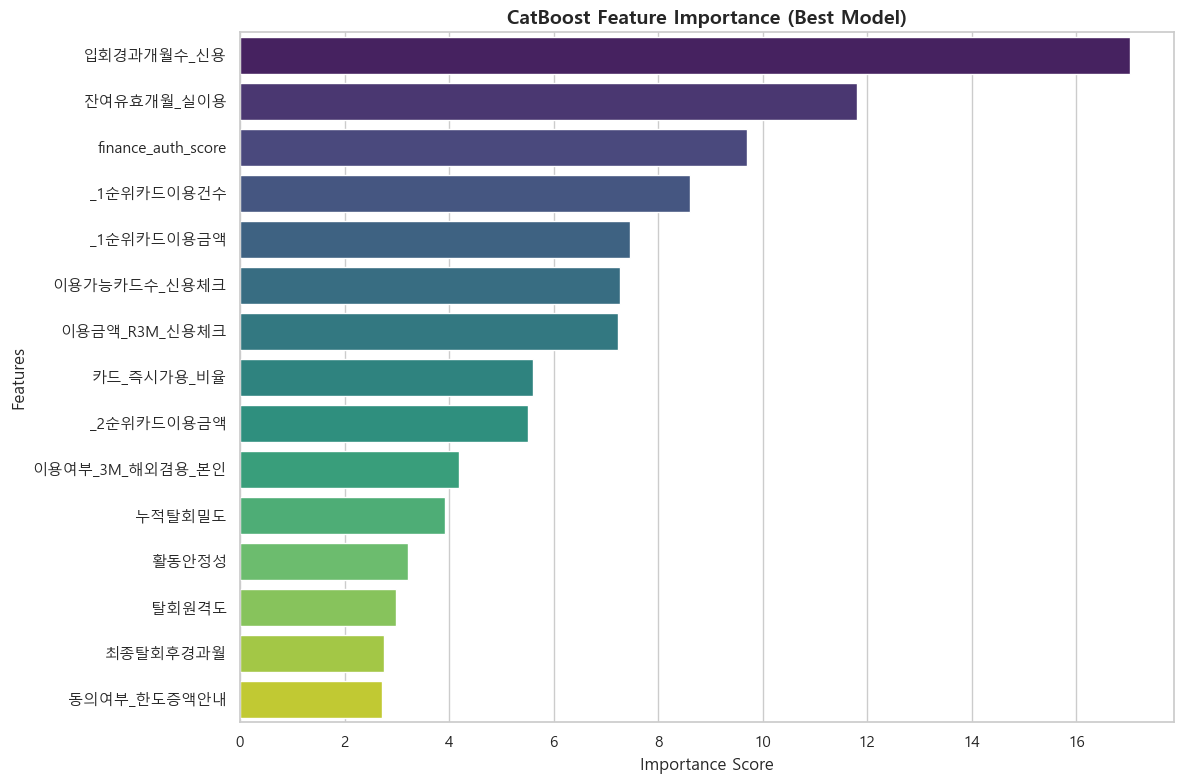


=== Top 10 Most Important Features ===
               Feature  Importance
11          입회경과개월수_신용   17.016611
5           잔여유효개월_실이용   11.797493
0   finance_auth_score    9.695501
8           _1순위카드이용건수    8.611793
7           _1순위카드이용금액    7.458821
10        이용가능카드수_신용체크    7.276959
6        이용금액_R3M_신용체크    7.234805
4           카드_즉시가용_비율    5.614338
9           _2순위카드이용금액    5.507927
12     이용여부_3M_해외겸용_본인    4.197344


In [106]:
# Best 모델에서 Feature Importance 시각화 (재학습 불필요 - 이미 위에서 저장됨)
# Feature Importance 추출
feature_importance = best_model.get_feature_importance()
feature_names = X_train.columns

# DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Seaborn으로 시각화
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')
plt.title('CatBoost Feature Importance (Best Model)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Top 20 Feature 시각화 (Feature가 많을 경우)
if len(importance_df) > 20:
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df.head(20), y='Feature', x='Importance', palette='rocket')
    plt.title('CatBoost Top 20 Feature Importance (Best Model)', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

# 상위 10개 Feature 출력
print("\n=== Top 10 Most Important Features ===")
print(importance_df.head(10))